# Fetching Weather Forecast and Analysis Data From MET Norway
We will try to use different techniques to fetch weather forecast data from MET Norway online services
1. Using a netCDF file downloaded from MET Norway's Thredds server for continuous archived weather data.
2. Using HTTP request from the 'locationforecast' online service.

In [1]:
# Install the following packages before using netCDF4, requests, pandas, numpy
# !pip install matplotlib numpy pandas json netCDF4 pyproj xarray
# !pip install requests
# !pip install openpyxl - to access excel methods of the dataframes
# !pip install earthengine-api
# !pip install rasterio
# !pip install openmeteo-requests
# !pip install requests-cache retry-requests

In [2]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import pyproj
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplt
import requests as requests
import json as json
from datetime import datetime
import openeo

In [3]:
# import ee
# ee.Authenticate()
# ee.Initialize(project='agrisenzebigdata')
# # Initialize the Earth Engine Python API

# # Define a region of interest (e.g., a point)
# point = ee.Geometry.Point(-122.262, 37.8719)

# # Load a Landsat image
# landsat = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
#     .filterBounds(point) \
#     .filterDate('2020-01-01', '2020-12-31') \
#     .first()

# # Print information about the image
# print('Landsat image:', landsat.getInfo())

## 1. Reading netCDF data downloaded from MET Norway latest weather analysis data

In [4]:
filename = "data/met_analysis_1_0km_nordic_latest.nc"
ncfile   = nc.Dataset(filename)
for variable in ncfile.variables:
    print(variable)

x
y
projection_lcc
time
forecast_reference_time
latitude
longitude
altitude
land_area_fraction
air_temperature_2m
air_pressure_at_sea_level
cloud_area_fraction
integral_of_surface_downwelling_longwave_flux_in_air_wrt_time
integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time
relative_humidity_2m
precipitation_amount
wind_speed_10m
wind_direction_10m


C:\Users\mamda\AppData\Local\Temp\ipykernel_5844\3429634675.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(longitudes, latitudes, temperature)


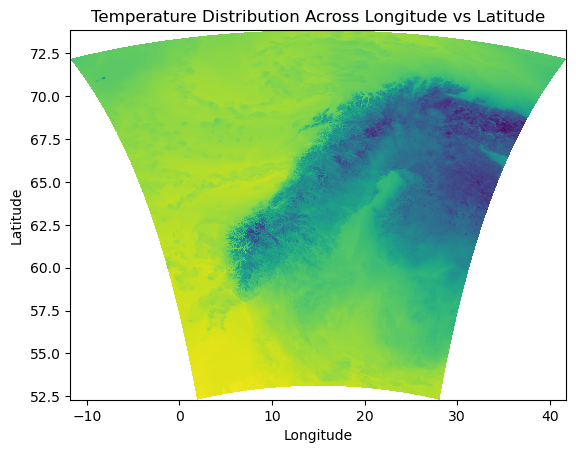

In [5]:
latitudes   = ncfile.variables["latitude" ][:]
longitudes  = ncfile.variables["longitude"][:]
timestep    = 0
temperature = ncfile.variables["air_temperature_2m"][timestep, :, :]

plt.pcolormesh(longitudes, latitudes, temperature)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature Distribution Across Longitude vs Latitude')
plt.xticks(rotation=0)
plt.show()

## To change the netCDF to pandas dataframe and JSON format

In [6]:
# Open the netCDF4 file
nc_file = nc.Dataset(filename)

# Extract data from the netCDF4 file
# For example, if you have variables 'time', 'temperature', and 'humidity'
time_data = nc_file.variables['time'][:]
temperature_data = nc_file.variables['air_temperature_2m'][:]
humidity_data = nc_file.variables['relative_humidity_2m'][:]

# Reshape or flatten arrays if necessary
time_data = time_data.flatten()
temperature_data = temperature_data.flatten()
humidity_data = humidity_data.flatten()

# Ensure time_data has the same length as temperature_data
if len(time_data) < len(temperature_data):
    last_time_value = time_data[-1]
    num_values_to_append = len(temperature_data) - len(time_data)
    time_data = list(time_data) + [last_time_value] * num_values_to_append

# Create a DataFrame
df = pd.DataFrame({
    'Time (Sec)': time_data,
    'Temperature (K)': temperature_data,
    'Relative Humidity': humidity_data
})

# Convert DataFrame to JSON format
json_data = df.to_json(orient='records')

# Print the first few records of the DataFrame and JSON data
print("DataFrame:", df.head())


DataFrame:      Time (Sec)  Temperature (K)  Relative Humidity
0  1.707314e+09       279.552338           0.768056
1  1.707314e+09       279.555573           0.768056
2  1.707314e+09       279.556763           0.763891
3  1.707314e+09       279.557983           0.763891
4  1.707314e+09       279.563446           0.763891


## 2. Fetching Weather Forecast data from MET Norway using HTTPS Request

In [7]:
# Initialize the expires and last_modified variables 
expire_time = None
last_modified = None

In [8]:
request_url = 'https://api.met.no/weatherapi/locationforecast/2.0/compact?lat=59.6603&lon=10.7817&altitude=93'

# Email address to include as User-Agent ID
user_agent = '259646@usn.no'

# Define headers with User-Agent
headers = {'User-Agent': user_agent, 'If-Modified-Since':last_modified}


# Send HTTP GET request with headers
response = requests.get(request_url, headers=headers)


# Check the response status code
if response.status_code == 200:
     # Save the expires and last_modified variables to avoid frequency request to the server
    expires_header = response.headers.get('expires')
    last_modified_header = response.headers.get('last-modified')

    # Convert expires and last_modified to RFC 1123 format
    expire_time = datetime.strptime(expires_header, '%a, %d %b %Y %H:%M:%S GMT').strftime('%a, %d %b %Y %H:%M:%S GMT')
    last_modified = datetime.strptime(last_modified_header, '%a, %d %b %Y %H:%M:%S GMT').strftime('%a, %d %b %Y %H:%M:%S GMT')
    data_json = response.json()
    # Request successful, print response content
    print(data_json)
else:
    # Request failed, print error message
    print(f"Error: {response.status_code}")

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [10.7817, 59.6603, 93]}, 'properties': {'meta': {'updated_at': '2024-03-27T21:46:13Z', 'units': {'air_pressure_at_sea_level': 'hPa', 'air_temperature': 'celsius', 'cloud_area_fraction': '%', 'precipitation_amount': 'mm', 'relative_humidity': '%', 'wind_from_direction': 'degrees', 'wind_speed': 'm/s'}}, 'timeseries': [{'time': '2024-03-27T21:00:00Z', 'data': {'instant': {'details': {'air_pressure_at_sea_level': 994.3, 'air_temperature': 3.6, 'cloud_area_fraction': 100.0, 'relative_humidity': 98.3, 'wind_from_direction': 332.5, 'wind_speed': 1.9}}, 'next_12_hours': {'summary': {'symbol_code': 'cloudy'}, 'details': {}}, 'next_1_hours': {'summary': {'symbol_code': 'cloudy'}, 'details': {'precipitation_amount': 0.0}}, 'next_6_hours': {'summary': {'symbol_code': 'cloudy'}, 'details': {'precipitation_amount': 0.0}}}}, {'time': '2024-03-27T22:00:00Z', 'data': {'instant': {'details': {'air_pressure_at_sea_level': 994.0, 'air_tempe

In [9]:
 len(data_json['properties']['timeseries'])

88

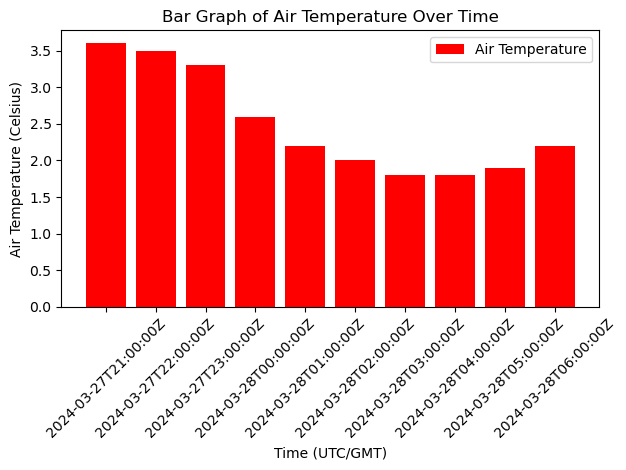

In [10]:
# Extract time and data values
time_values = [item['time'] for item in data_json['properties']['timeseries']]
data_values = [item['data']['instant']['details']['air_temperature'] for item in data_json['properties']['timeseries']]

# Create DataFrame
df = pd.DataFrame({'Time': time_values[:10], 'Air Temperature': data_values[:10]})

# Plot bar graph
plt.bar(df['Time'], df['Air Temperature'], color='red')
plt.xlabel('Time (UTC/GMT)')
plt.ylabel('Air Temperature (Celsius)')
plt.title('Bar Graph of Air Temperature Over Time')
plt.xticks(rotation=45)
plt.legend(['Air Temperature'])
plt.tight_layout()
plt.show()


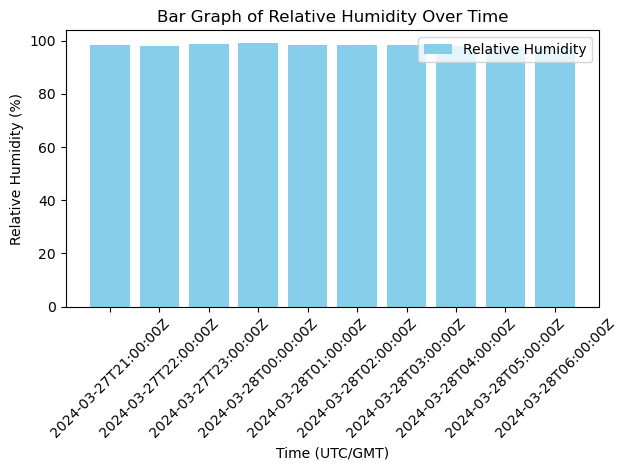

In [11]:
# Extract time and data values
time_values = [item['time'] for item in data_json['properties']['timeseries']]
data_values = [item['data']['instant']['details']['relative_humidity'] for item in data_json['properties']['timeseries']]

# Create DataFrame
df = pd.DataFrame({'Time': time_values[:10], 'Relative Humidity': data_values[:10]})

# Plot bar graph
plt.bar(df['Time'], df['Relative Humidity'], color='skyblue')
plt.xlabel('Time (UTC/GMT)')
plt.ylabel('Relative Humidity (%)')
plt.title('Bar Graph of Relative Humidity Over Time')
plt.xticks(rotation=45)
plt.legend(['Relative Humidity'])
plt.tight_layout()
plt.show()

In [12]:
data_values[82]
time_values[0]

'2024-03-27T21:00:00Z'

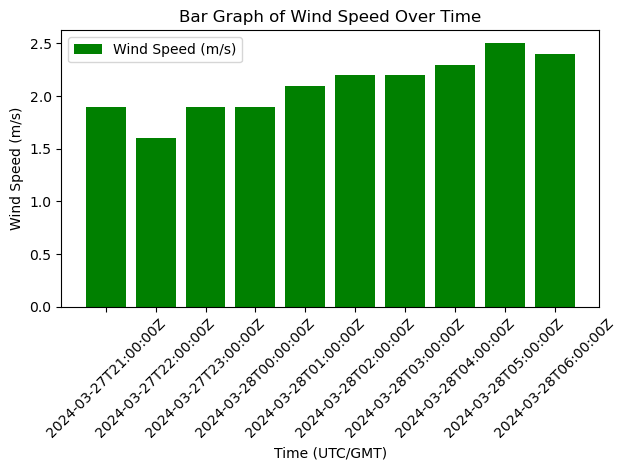

In [13]:
# Extract time and data values
time_values = [item['time'] for item in data_json['properties']['timeseries']]
data_values = [item['data']['instant']['details']['wind_speed'] for item in data_json['properties']['timeseries']]

# Create DataFrame
df = pd.DataFrame({'Time': time_values[:10], 'Wind Speed': data_values[:10]})

# Plot bar graph
plt.bar(df['Time'], df['Wind Speed'], color='green')
plt.xlabel('Time (UTC/GMT)')
plt.ylabel('Wind Speed (m/s)')
plt.title('Bar Graph of Wind Speed Over Time')
plt.xticks(rotation=45)
plt.legend(['Wind Speed (m/s)'])
plt.tight_layout()
plt.show()

## 3. Fetching Archived historical weather and climate data from MET Norway using RESTful API

In [14]:
# You need to first register your email and get the client Id and secret codes. (https://frost.met.no/auth/requestCredentials.html)
# Insert your own client ID here
import requests
client_id = '732d88c6-1b10-40a3-8c2b-184d03ac49e8'
# Define endpoint and parameters
endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': 'SN17850', # For ÅS NMBU station Id
    'elements': 'mean(wind_speed P1D)',
    'referencetime': '2018-01-01/2022-01-31'
    # 'qualities':'0'
    # 'levels':'default',
    # 'timeoffsets': 'default'
}
"""
mean(air_temperature P1D): Daily mean temperature. The mean is an arithmetic mean of 24 hourly values (00-00 UTC), or a formula based mean value when 
only a limited number of observations is available (e.g. 06, 12, 18 UTC) at 2m height.
mean(air_temperature P1M): Monthly mean temperature. The mean is an arithmetic mean of daily values
mean(air_temperature P1Y): Annual mean temperature. The mean is an arithmetic mean of daily values.
mean(air_temperature P3M): Seasonal mean air temperature. Winter (Dec,Jan,Feb), spring (Mar,Apr,May), summer (Jun,Jul,Aug) and autumn (Sep,Oct,Nov). 
The mean is an arithmetic mean of daily values.
mean(air_temperature P6M): Mean air temperature during winter (October-March) or summer (April-September)
mean(relative_humidity P1D): Daily mean relative humidity.
mean(relative_humidity P1M): Monthly mean relative humidity.
mean(relative_humidity P3M): Seasonal mean relative humidity. A season covers three months: Winter (Dec,Jan,Feb), spring (Mar,Apr,May), 
summer (Jun,Jul,Aug) and autumn (Sep,Oct,Nov)
soil_temperature: Soil temperature at given depth (default 10 cm)
mean(soil_temperature P1D): Mean soil temperature at given depth (default 10 cm), mean value over 24 hours. Calculated based on hourly or 6-hourly data.
mean(soil_temperature PT1H): Mean soil temperature at given depth (default 10 cm), mean value over 1 hour
mean(surface_air_pressure P1D): Daily mean air pressure at the station. The parameter is usually called QFE in aviation and shows the measured air pressure 
reduced to the reference height of the station in hPa.
mean(surface_air_pressure P1M): Monthly mean air pressure at the station. The parameter is usually called QFE in aviation and shows the measured air pressure 
reduced to the reference height of the station in hPa similarly mean(surface_air_pressure P1Y) and mean(surface_air_pressure P3M) and mean(surface_air_pressure P1D).
mean(wind_speed P1D): Daily mean wind speed of hourly observations (00, 01, 02,..., 23 UTC). If hourly observations do not exist then the main observation times are 
used (06, 12, 18 UTC and also 00 UTC where available). Similarly mean(wind_speed P1M), mean(wind_speed P3M), 
sum(precipitation_amount P1D): Daily precipitation sum (between 06-06 UTC).
sum(precipitation_amount P1M): Monthly precipitation sum. Similarly, sum(precipitation_amount P1Y), sum(precipitation_amount P3M), sum(precipitation_amount P6M)
best_estimate_mean(air_temperature P1D) : Homogenised daily mean temperature. The mean is an arithmetic mean of 24 hourly values (00-00 UTC), 
or a formula based mean value when only a limited number of observations is available (e.g. 06, 12, 18 UTC) at 2m above ground.
best_estimate_mean(air_temperature P1M) :  Homogenised monthly mean temperature. The mean is an arithmetic mean of daily values at 2m above ground
best_estimate_mean(air_temperature P1Y) : Homogenised annual mean temperature. The mean is an arithmetic mean of daily values at 2m above ground
best_estimate_mean(air_temperature P3M) : Homogenised seasonal mean temperature. Winter (Dec,Jan,Feb), spring (Mar,Apr,May), summer (Jun,Jul,Aug) 
and autumn (Sep,Oct,Nov). The mean is an arithmetic mean of daily values.
best_estimate_mean(air_temperature P6M): Homogenised mean temperature during winter (October-March) or summer (April-September). The mean is an 
arithmetic mean of daily values
best_estimate_sum(precipitation_amount P1D): Homogenised daily precipitation sum
best_estimate_sum(precipitation_amount P1M) : Homogenised monthly precipitation sum
best_estimate_sum(precipitation_amount P1Y): Homogenised annual precipitation sum
best_estimate_sum(precipitation_amount P3M): Homogenised seasonal precipitation sum
best_estimate_sum(precipitation_amount P6M) : Homogenised precipitation half-year sum (summer half-year and winter half-year)
max(air_temperature P1D): Highest recorded air temperature per 24 hours
max(air_temperature P1M): Highest recorded air temperature per month
max(air_temperature P1Y): Highest recorded air temperature per year
max(air_temperature P3M): Highest recorded air temperature per season. Winter (Dec,Jan, Feb), spring (Mar,Apr,May), 
summer (Jun,Jul,Aug), autumn (Sep,Oct,Nov).
max(air_temperature P6M): Highest recorded air temperature during winter (October-March) or summer (April-September)
max(relative_humidity P1D), max(relative_humidity P1M), max(relative_humidity P1Y), max(relative_humidity P3M), max(relative_humidity P6M)
max(sum(precipitation_amount P1D) P1M): Maximum daily precipitation sum (between 06-06 UTC) registered per month
max(wind_speed P1D): Daily maximum mean wind speed of hourly observations (00, 01, 02,..., 23 UTC). If hourly observations do not exist then the 
main observation times are used (06, 12, 18 UTC and also 00 UTC where available).
max(wind_speed P1M), max(wind_speed P3M), 

The basic forms available for expressing time in Frost are as follows:
date: YYYY-MM-DD
time: hh:mm:ss
datetime: <date>T<time>
interval (from, to): <datetime>/<datetime>

For further (more complicated) specification of time intervals the concepts below can be used:
Period: P #
Y (year), M (month), W (week), D (day), T (time), H (hour), M (minute), S (second)
repetions of the interval: Rn/<datetime>/<datetime>
for example: R4/2017-01-01/2017-01-02 this gives you data for 1 day, repeated over 4 days. However this is really no different than defining the full time range 2017-01-01/2017-01-05
repeating intervals with explicit starting point distance: Rn/<datetime>/<datetime>/<period>
for example: R2/2017-01-01/2017-02-01/P1Y (see drawing below)
repeating time points: Same as repeating intervals with explicit starting point distance, but with the added restriction that the two times of the interval are identical.
for example: R4/2017-01-01T12/2017-01-01T12/P1D (see drawing below)

Geometric definitions
POINT(10 59):	Refer to the exact point given by the geometry object with longitude 10 and latitude 59 in WGS84 projection.
nearest(POINT(10 59)):	Refer to the item closest to longitude 10 and latitude 59.
POLYGON((10 59, 10 60, 11 60, 11 59, 10 59)):	Refer to the items inside the polygon starting with longitude 10 and latitude 59 etc. 
Note: polygons with holes are not supported by the Frost API.

"""
# Issue an HTTP GET request
res = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = res.json()
# Check if the request worked, print out any errors
if res.status_code == 200:
    data = json['data']
    df = pd.DataFrame()
    for i in range(len(data)):
        row = pd.DataFrame(data[i]['observations'])
        row['referenceTime'] = data[i]['referenceTime']
        row['sourceId'] = data[i]['sourceId']
        df_new = pd.DataFrame(row)
        df = pd.concat([df, df_new], ignore_index=True)
    df = df.reset_index()
else:
    print('Error! Returned status code %s' % res.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Error! Returned status code 412
Message: 412
Reason: No time series found for this combination of parameters, check /observations/availableTimeSeries for more information.


In [15]:
df.head(100)

,Time,Wind Speed
0,2024-03-27T21:00:00Z,1.9
1,2024-03-27T22:00:00Z,1.6
2,2024-03-27T23:00:00Z,1.9
3,2024-03-28T00:00:00Z,1.9
4,2024-03-28T01:00:00Z,2.1
5,2024-03-28T02:00:00Z,2.2
6,2024-03-28T03:00:00Z,2.2
7,2024-03-28T04:00:00Z,2.3
8,2024-03-28T05:00:00Z,2.5
9,2024-03-28T06:00:00Z,2.4


In [16]:
# import struct
# HEADER_SIZE=12
# RECORD_SIZE=128
# BUFFER=12
# def read_pssession_file(file_path):
#     with open(file_path, 'rb') as f:
#         # Read the header
#         header_data = f.read(HEADER_SIZE)
#         # Parse the header (assuming it's a fixed-size structure)
#         version, session_id, timestamp = struct.unpack(BUFFER, header_data)
#         # Process the header information
#         print(f"Version: {version}, Session ID: {session_id}, Timestamp: {timestamp}")

#         # Read and parse the data records
#         while True:
#             record_data = f.read(RECORD_SIZE)
#             if not record_data:
#                 break  # End of file
#             # Parse the record (assuming it's a fixed-size structure)
#             field1, field2, field3 = struct.unpack(RECORD_SIZE, record_data)
#             # Process the record data
#             print(f"Field 1: {field1}, Field 2: {field2}, Field 3: {field3}")

# # Example usage
# read_pssession_file('data/Nitrate 231205.pssession')


In [17]:
import rasterio

# Path to the HWSD raster file (.bil)
hwsd_file = "data/Harmonized World Soil Database/HWSD_RASTER/hwsd.bil"

# Open the HWSD raster file
with rasterio.open(hwsd_file) as src:
    # Read the raster data
    hwsd_data = src.read()  # Read the first band (assuming single-band raster)
    # Get the metadata
    hwsd_meta = src.meta
hwsd_meta

# Now you can work with the HWSD data (e.g., analyze, visualize, etc.)
# The hwsd_data variable contains the raster data as a NumPy array
# The hwsd_meta variable contains metadata such as spatial extent, resolution, etc.



{'driver': 'EHdr',
 'dtype': 'uint16',
 'nodata': None,
 'width': 43200,
 'height': 21600,
 'count': 1,
 'crs': None,
 'transform': Affine(0.00833333333333, 0.0, -180.0,
        0.0, -0.00833333333333, 89.99999999992804)}

In [18]:
hwsd_data.shape

(1, 21600, 43200)

In [19]:
# url = "https://api.digifarm.io/v1/delineated-fields/location"

# headers = {"accept": "application/json"}

# response = requests.get(url, headers=headers)

# print(response.text)
# # response

In [20]:
# import fiona
# gdb_file_path = "data/38_25833_jordkvalitet_gdb"
# # Read the GDB file using fiona
# with fiona.open(gdb_file_path, "r", allow_unsupported_drivers=True) as gdb:
#     # Iterate over features in the GDB file
#     for feature in gdb:
#         # Process each feature as needed
#         print(feature)

## 4. Fetching weather and climate data from Open Meteo using RESTful API

### Install openmeteo-requests reference (https://open-meteo.com/en/docs)
### pip install openmeteo-requests

### Install the requests-cache and retry-requests library
### pip install requests-cache retry-requests

In [23]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 59.66,
	"longitude": 10.78,
	"hourly": ["temperature_2m","precipitation", "wind_speed_10m", "wind_direction_10m", "rain", "soil_temperature_6cm", "soil_temperature_54cm", "","soil_moisture_3_to_9cm", "soil_moisture_27_to_81cm"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
precipitation = hourly.Variables(1).ValuesAsNumpy()
wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
wind_direction_10m = hourly.Variables(3).ValuesAsNumpy()
rain = hourly.Variables(4).ValuesAsNumpy()
soil_temperature_6cm = hourly.Variables(5).ValuesAsNumpy()
soil_temperature_54cm = hourly.Variables(6).ValuesAsNumpy()
soil_moisture_3_to_9cm = hourly.Variables(7).ValuesAsNumpy()
soil_moisture_27_to_81cm = hourly.Variables(8).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = precipitation
hourly_data["wind_speed_10m"] = wind_speed_10m
hourly_data["wind_direction_10m"] = wind_direction_10m
hourly_data["rain"] = rain
hourly_data["soil_temperature_6cm"] = soil_temperature_6cm
hourly_data["soil_temperature_54cm"] = soil_temperature_54cm
hourly_data["soil_moisture_3_to_9cm"] = soil_moisture_3_to_9cm
hourly_data["soil_moisture_27_to_81cm"] = soil_moisture_27_to_81cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.head(20)

Coordinates 59.6554069519043°N 10.776992797851562°E
Elevation 94.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m,rain,soil_temperature_6cm,soil_temperature_54cm,soil_moisture_3_to_9cm,soil_moisture_27_to_81cm
0,2024-03-27 00:00:00+00:00,1.537,0.1,18.000000,116.0,0.1,0.6305,1.0305,0.307,0.315
1,2024-03-27 01:00:00+00:00,1.637,0.0,15.840000,117.0,0.0,0.5805,1.0305,0.307,0.315
2,2024-03-27 02:00:00+00:00,1.437,0.0,15.480000,107.0,0.0,0.4805,1.0305,0.306,0.315
3,2024-03-27 03:00:00+00:00,1.437,0.0,16.919998,100.0,0.0,0.4305,1.0305,0.306,0.315
4,2024-03-27 04:00:00+00:00,1.687,0.0,17.280001,97.0,0.0,0.3305,1.0305,0.305,0.315
5,2024-03-27 05:00:00+00:00,1.637,0.0,15.840000,92.0,0.0,0.4805,1.0305,0.304,0.315
6,2024-03-27 06:00:00+00:00,2.187,0.0,13.320000,82.0,0.0,0.5805,1.0305,0.304,0.315
7,2024-03-27 07:00:00+00:00,2.587,0.0,9.000000,79.0,0.0,0.6305,1.0305,0.305,0.315
8,2024-03-27 08:00:00+00:00,2.887,0.0,9.720000,76.0,0.0,0.8305,1.0305,0.306,0.316
9,2024-03-27 09:00:00+00:00,3.087,0.0,10.080000,74.0,0.0,1.2305,1.0305,0.308,0.316


## 5. Fetching Soil characteristics data from ISRIC SoilGrids API

In [24]:
import requests


# replace with actual longitude and latitude
"""
Name:	Description	Mapped units:	Conversion factor:	Conventional units
bdod:	Bulk density of the fine earth fraction:	cg/cm³:	100:	kg/dm³
cec:	Cation Exchange Capacity of the soil:	mmol(c)/kg:	10:	cmol(c)/kg
cfvo:	Volumetric fraction of coarse fragments (> 2 mm):	cm3/dm3 (vol‰):	10:	cm3/100cm3 (vol%)
clay:	Proportion of clay particles (< 0.002 mm) in the fine earth fraction:	g/kg:	10:	g/100g (%)
nitrogen:	Total nitrogen (N):	cg/kg:	100:	g/kg
phh2o:	Soil pH	pHx10:	10:	pH
sand	Proportion of sand particles (> 0.05 mm) in the fine earth fraction	g/kg	10	g/100g (%)
silt	Proportion of silt particles (≥ 0.002 mm and ≤ 0.05 mm) in the fine earth fraction	g/kg	10	g/100g (%)
soc	Soil organic carbon content in the fine earth fraction	dg/kg	10	g/kg
ocd	Organic carbon density	hg/m³	10	kg/m³
ocs	Organic carbon stocks	t/ha	10	kg/m²

uncertainty = (Q0.95-Q0.05)/Q0.50 : This inter-quantile range (90% prediction interval width) and the median. The values are multiplied by 10 in order to have integers and reduce the size of the datasets 
"""
longitude = 10.7818
latitude = 59.6605
query_string = 'property=bdod&property=cec&property=cfvo&property=clay&property=nitrogen&property=ocd&property=ocs&property=phh2o&property=sand& \
property=silt&property=soc&property=wv0010&property=wv0033&property=wv1500&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm& \
depth=60-100cm&depth=100-200cm&value=Q0.05&value=Q0.5&value=Q0.95&value=mean&value=uncertainty'
# make request to properties endpoint
response = requests.get(f"https://rest.isric.org/soilgrids/v2.0/properties/query?lon={longitude}&lat={latitude}&{query_string}")

# # parse response
data = response.json()
# continue with your application logic...
# Extracting data
columns = []
for layer in data['properties']['layers']:
    layer_name = layer['name']
    for depth in layer['depths']:
        column_name = f"{layer_name}_{depth['label']} ({layer['unit_measure']['target_units']})"
        columns.append(column_name)

index = ['mean', 'uncertainty']
# Calculate the total number of depths
total_depths = sum(len(layer['depths']) for layer in data['properties']['layers'])

# Construct the data_matrix
data_matrix = np.zeros((len(index), total_depths), dtype=int)

# Populate the data_matrix
current_column_index = 0
for i, layer in enumerate(data['properties']['layers']):
    for j, depth in enumerate(layer['depths']):
        mean = depth['values']['mean']
        uncertainty = depth['values']['uncertainty']
        data_matrix[0, current_column_index] = mean
        data_matrix[1, current_column_index] = uncertainty
        current_column_index += 1  # Move to the next column

# Constructing DataFrame
df = pd.DataFrame(data_matrix, index=index, columns=columns)
# Define the file path where you want to save the Excel file
excel_file_path = "data/outputs/ISRIC_soil_properties.xlsx"

# Save the DataFrame to Excel
df.to_excel(excel_file_path, index=True)  # Set index=True if you want to include row names in the Excel file
df

,bdod_0-5cm (kg/dm³),bdod_5-15cm (kg/dm³),bdod_15-30cm (kg/dm³),bdod_30-60cm (kg/dm³),bdod_100-200cm (kg/dm³),cec_0-5cm (cmol(c)/kg),cec_5-15cm (cmol(c)/kg),cec_15-30cm (cmol(c)/kg),cec_30-60cm (cmol(c)/kg),cec_100-200cm (cmol(c)/kg),...,wv0033_0-5cm (10-2 cm³/cm³),wv0033_5-15cm (10-2 cm³/cm³),wv0033_15-30cm (10-2 cm³/cm³),wv0033_30-60cm (10-2 cm³/cm³),wv0033_100-200cm (10-2 cm³/cm³),wv1500_0-5cm (10-2 cm³/cm³),wv1500_5-15cm (10-2 cm³/cm³),wv1500_15-30cm (10-2 cm³/cm³),wv1500_30-60cm (10-2 cm³/cm³),wv1500_100-200cm (10-2 cm³/cm³)
mean,80,109,119,132,146,309,235,171,166,153,...,397,340,326,317,303,138,142,125,107,119
uncertainty,18,12,11,9,9,40,52,32,42,45,...,9,11,11,12,11,12,12,19,26,27


### Request to properties endpoint

In [25]:
import requests

# replace with actual longitude and latitude
longitude = 10.7817
latitude = 59.6603

# make request to properties endpoint
response = requests.get(f"https://rest.isric.org/soilgrids/v2.0/properties/query?lon={longitude}&lat={latitude}&property=clay&property=sand&depth=0-5cm&value=mean&value=uncertainty")

# parse response
data = response.json()
# continue with your application logic...
data

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [10.7817, 59.6603]},
 'properties': {'layers': [{'name': 'clay',
    'unit_measure': {'d_factor': 10,
     'mapped_units': 'g/kg',
     'target_units': '%',
     'uncertainty_unit': ''},
    'depths': [{'range': {'top_depth': 0,
       'bottom_depth': 5,
       'unit_depth': 'cm'},
      'label': '0-5cm',
      'values': {'mean': 179, 'uncertainty': 90}}]},
   {'name': 'sand',
    'unit_measure': {'d_factor': 10,
     'mapped_units': 'g/kg',
     'target_units': '%',
     'uncertainty_unit': ''},
    'depths': [{'range': {'top_depth': 0,
       'bottom_depth': 5,
       'unit_depth': 'cm'},
      'label': '0-5cm',
      'values': {'mean': 425, 'uncertainty': 19}}]}]},
 'query_time_s': 0.28793978691101074}

### Request to property layers endpoint

In [26]:
import requests

# replace with actual longitude and latitude
longitude = 10.7817
latitude = 59.6603

# make request to properties endpoint
response = requests.get(f"https://rest.isric.org/soilgrids/v2.0/properties/layers")

# parse response
data = response.json()
# continue with your application logic...
data

{'layers': [{'property': 'bdod',
   'layer_structure': [{'range': '0-5cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '5-15cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '15-30cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '30-60cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '60-100cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '100-200cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']}]},
  {'property': 'cec',
   'layer_structure': [{'range': '0-5cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '5-15cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '15-30cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'uncertainty']},
    {'range': '30-60cm',
     'values': ['Q0.05', 'Q0.5', 'Q0.95', 'mean', 'unce

### Request to classifications endpoint

In [27]:
import requests

# replace with actual longitude and latitude
longitude = 10.7817
latitude = 59.6603

# make request to classification endpoint
response = requests.get(f"https://rest.isric.org/soilgrids/v2.0/classification/query?lon={longitude}&lat={latitude}&number_classes=30")

# parse response
data = response.json()
# continue with your application logic...
data

{'type': 'Point',
 'coordinates': [10.7817, 59.6603],
 'query_time_s': 2.6123430728912354,
 'wrb_class_name': 'Cambisols',
 'wrb_class_value': 6,
 'wrb_class_probability': [['Cambisols', 35],
  ['Gleysols', 26],
  ['Podzols', 13],
  ['Luvisols', 11],
  ['Fluvisols', 5],
  ['Andosols', 2],
  ['Histosols', 2],
  ['Phaeozems', 2],
  ['Albeluvisols', 1],
  ['Planosols', 1],
  ['Regosols', 1],
  ['Acrisols', 0],
  ['Cryosols', 0],
  ['Calcisols', 0],
  ['Chernozems', 0],
  ['Gypsisols', 0],
  ['Ferralsols', 0],
  ['Arenosols', 0],
  ['Durisols', 0],
  ['Nitisols', 0],
  ['Kastanozems', 0],
  ['Leptosols', 0],
  ['Plinthosols', 0],
  ['Alisols', 0],
  ['Lixisols', 0],
  ['Solonchaks', 0],
  ['Solonetz', 0],
  ['Umbrisols', 0],
  ['Stagnosols', 0],
  ['Vertisols', 0]]}

## 6. Crop Assessment using Cool Farm Tool

In [28]:
# API Key: my1XUAvGh1sLjuoSEpGkBSzc2jh39NKksOSC5HmvCcI
import requests
import json
# insert your API key and include in headers
API_KEY = "my1XUAvGh1sLjuoSEpGkBSzc2jh39NKksOSC5HmvCcI"
HEADERS = {
    "Content-Type": "application/json",
    "X-API-Authorization": API_KEY
}

# calculate crop product
crop_input = json.loads('''
[
  {
    "farm": {
      "country": "Norway",
      "territory": "As",
      "climate": "Cool Temperate Moist",
      "average_temperature": {
        "value": 6,
        "unit": "°C"
      },
      "soil_characteristics": "Sandy Soils",
      "farm_identifier": "",
      "latitude": 10.78,
      "longitude": 59.66
    },
    "crop": {
      "type": "Wheat",
      "harvesting_year": 2023,
      "feed_type": null,
      "field_size": {
        "value": 100,
        "unit": "ha"
      },
      "soil": {
        "texture_id": 1,
        "organic_matter_id": 2,
        "drainage_id": 1,
        "ph_id": 4,
        "organic_matter_custom": null,
        "custom_measured_years_ago": 0
      },
      "product_fresh": {
        "value": 1000,
        "unit": "tonne"
      },
      "product_finished": {
        "value": 990,
        "unit": "tonne"
      },
      "residue": {
        "value": null,
        "unit": null,
        "management": "Left distributed on field, OR incorporated, OR mulched"
      },
      "seed_amount": {
        "value": 10,
        "unit": "tonne"
      },
      "irrigation_calculation_type": "volume_depth_distance_irrigation_type"
    },
    "pesticides": [
      {
        "type_id": 1,
        "category_id": 3,
        "percentage_rate": 100,
        "application_rate": {
          "value": 1,
          "unit": "kg / acre"
        }
      }
    ],
    "fertilisers": [
      {
        "type": "Compose your own NPK",
        "production": "Europe 2014",
        "custom_ingredients": {
          "n_total_percentage": 0,
          "n_ammonia_percentage": 0,
          "n_nitric_percentage": 0,
          "n_urea_percentage": 0,
          "p2o5_percentage": 0,
          "p2o5_percentage_type_id": 4,
          "k2o_percentage": 0,
          "k2o_percentage_type_id": 5
        },
        "application_rate": {
          "value": 15,
          "unit": "kg / ha"
        },
        "application_date": "unknown",
        "rate_measure": "product",
        "method": 2,
        "inhibition_id": 1
      }
    ],
    "machinery": [
      {
        "operations": 1,
        "machinery": 24,
        "fuel_type": "diesel (average biofuel blend)"
      }
    ],
    "irrigation": [
      {
        "method": 1,
        "water_source": 1,
        "allocation": 100,
        "pumping_depth": {
          "value": 1,
          "unit": "m"
        },
        "horizontal_distance": {
          "value": 2,
          "unit": "km"
        },
        "water_added": {
          "value": 2,
          "unit": "ha-mm"
        },
        "power_source": 1
      }
    ],
    "direct_energy": [
      {
        "category": "irrigation",
        "source": "diesel (average biofuel blend)",
        "usage": {
          "value": 1000,
          "unit": "litre"
        }
      }
    ],
    "land_management": {
      "carbon_changes": [
        {
          "year_of_change": 2021,
          "allocation": 100,
          "land_use": {
            "from": "cultivated",
            "to": "set-aside"
          },
          "tillage": {
            "from": "reduced",
            "to": "no-till"
          },
          "inputs": {
            "from": "low-c-input",
            "to": "high-c-input-with-manure"
          }
        },
        {
          "year_of_change": 2020,
          "allocation": 44,
          "land_use": {
            "from": "native-forest",
            "to": "cultivated"
          },
          "tillage": {
            "from": "full",
            "to": "reduced"
          },
          "inputs": {
            "from": "high-c-input-without-manure",
            "to": "low-c-input"
          }
        },
        {
          "year_of_change": 2019,
          "allocation": 100,
          "land_use": {
            "from": "native-forest",
            "to": "native-forest"
          },
          "tillage": {
            "from": "reduced",
            "to": "full"
          },
          "inputs": {
            "from": "high-c-input-with-manure",
            "to": "high-c-input-without-manure"
          }
        },
        {
          "year_of_change": 2017,
          "allocation": 29,
          "land_use": {
            "from": "native-forest",
            "to": "native-forest"
          },
          "tillage": {
            "from": "no-till",
            "to": "reduced"
          },
          "inputs": {
            "from": "medium-c-input",
            "to": "high-c-input-with-manure"
          }
        }
      ],
      "forest_biomass": {
        "age_years": 5,
        "type": "boreal mountain system"
      }
    },
    "transport": [
      {
        "mode": "road LGV diesel (light goods vehicle <3.5t)",
        "weight": {
          "value": 4,
          "unit": "tonne"
        },
        "distance": {
          "value": 2000,
          "unit": "km"
        }
      }
    ],
    "tree_biomass": [
      {
        "tree_type": 5,
        "density_last_year": {
          "value": 100,
          "unit": "trees / hectare"
        },
        "size_last_year": {
          "value": 10,
          "unit": "cm"
        },
        "size_this_year": {
          "value": 15,
          "unit": "cm"
        },
        "num_trees_delta": {
          "value": 1,
          "unit": "trees / hectare"
        }
      }
    ],
    "co_products": [
      {
        "name": "test_co_product",
        "percentage_main_value": 50
      }
    ],
    "processing": [
      {
        "_type": 1,
        "allocation": 100,
        "power_source": 102
      }
    ],
    "storage": [
      {
        "cipc_application": 1,
        "cipc_dose": 1,
        "storage_power_source": 106,
        "store_loading_power_source": 102,
        "unloading_power_source": 102,
        "stored_allocation": 100,
        "temperature": {
          "unit": "°C",
          "value": 5
        },
        "time": {
          "unit": 46,
          "value": 1
        }
      }
    ],
    "waste_water": {
      "waste_water_production": {
        "unit": 15,
        "value": 12
      },
      "oxygen_demand": {
        "unit": 18,
        "value": 15
      },
      "oxygen_demand_type": 1,
      "water_treatment_type": 1
    }
  },
  {
    "information": {
      "cft_version": "API_DEMO_TOOL"
    }
  }
]
''')

crop_output = requests.post("https://app.coolfarmtool.org/api/v1/crop_product/calculate/", json=crop_input, headers=HEADERS)
crop_output

<Response [405]>

## A function to extract address from longitude and latitude

In [33]:
#!pip install geopy

In [34]:
from geopy.geocoders import Nominatim
def get_address_details(latitude, longitude, altitude=None):
    # Initialize Nominatim geocoder
    geolocator = Nominatim(user_agent="tsegazeabtedla@gmail.com")
    # Combine latitude and longitude into a single string
    location = f"{latitude}, {longitude}"
    # Perform reverse geocoding
    location_info = geolocator.reverse(location, exactly_one=True)
    # Extract country and territory names
    if location_info:
        address = location_info.raw['address']
        return address
    else:
        return None

# Example usage
latitude = 9.0192  # Example latitude (e.g., AS NMBU)
longitude = 38.7525  # Example longitude (e.g., AS NMBU)
altitude = 93.3 # Example altitude (e.g., AS NMBU)
address= get_address_details(latitude, longitude)
print("Address:", address)

Address: {'road': 'Yared Street', 'neighbourhood': 'አምባሳደር', 'suburb': 'አገናኝደቂቅ ፕሮጀክት Microlink Project', 'county': 'Lideta', 'state_district': 'አዲስ አበባ / Addis Ababa', 'state': 'አዲስ አበባ', 'ISO3166-2-lvl4': 'ET-AA', 'postcode': '1910', 'country': 'ኢትዮጵያ', 'country_code': 'et'}


## 7. Minute based weather periodic data from Frost API MET Norway (ref: https://github.com/ArcticPuffin/frost_api_metno/blob/master/frost_function.py)

In [31]:
#!/usr/bin/python

"""

This program shows how to retrieve a time series of observations from the following
combination of source, element and time range:

source:     SN18700
element:    mean(wind_speed P1D)
time range: 2010-04-01 .. 2010-05-31

The time series is written to standard output as lines of the form:

  <observation time as date/time in ISO 8601 format> \
  <observation time as seconds since 1970-01-01T00:00:00> \
  <observed value>

Save the program to a file example.py, make it executable (chmod 755 example.py),
and run it e.g. like this:

  $ CLIENTID=8e6378f7-b3-ae4fe-683f-0db1eb31b24ec ./example.py

(Note: the client ID used in the example should be replaced with a real one)

The program has been tested on the following platforms:
  - Python 2.7.3 on Ubuntu 12.04 Precise
  - Python 2.7.12 and 3.5.2 on Ubuntu 16.04 Xenial

"""

import pandas as pd
import sys, os
import dateutil.parser as dp
import requests # See http://docs.python-requests.org/
voi = 'mean(air_temperature P1M), mean(relative_humidity P1M), mean(soil_temperature P1M), mean(surface_air_pressure P1M), sum(precipitation_amount P1M)'
station = 'SN17850'
start = '2024-01-01'
end = '2024-04-01'
client_id = "732d88c6-1b10-40a3-8c2b-184d03ac49e8"

def get_metno_data(station, voi, start, end, client_id):
    """
    function to collect data from metno.
    required arguments:
    station: the station ID of the station you want to retrieve data
    voi: string of variables of interest, for example 'air_temperature, wind_speed, relative_humidity'
    start: start date, for example '2010-04-01'
    end: end date, for example '2010-06-01'
    client_id: your ID to identify yourself to the database. You can get this from here: https://frost.met.no/auth/requestCredentials.html

    What is unclear:
    - How to set time resolution?
    - What are all the possible variable names?
    - Where to find available station IDs

    This function follows the metno example. https://frost.met.no/langex_python
    """


    try:
        # issue an HTTP GET request
        response = requests.get(
            'https://frost.met.no/observations/v0.jsonld',
            {'sources': station, 
             'elements': voi, #, sum(precipitation_amount PT12H)', 
             'referencetime': start+'/'+end},
            auth=(client_id, '')
        )

        time = []
        data = {}

        # extract the time series from the response
        if response.status_code == 200:
            for element in range(0, len(response.json()['data'][0]['observations'])):
                data[response.json()['data'][0]['observations'][element]['elementId']] = []
            for item in response.json()['data']:
                iso8601 = item['referenceTime']
                secsSince1970 = dp.parse(iso8601).timestamp()
                time.append(iso8601)
                for element in range(0, len(item['observations'])):
                    data.update({item['observations'][element]['elementId'] : item['observations'][element]['value']})
        
            # # Limit data list to match the length of time list
            # data = {key: values[:len(time)] for key, values in data.items()}
        else:
            sys.stdout.write('error:\n')
            sys.stdout.write('\tstatus code: {}\n'.format(response.status_code))
            if 'error' in response.json():
                assert(response.json()['error']['code'] == response.status_code)
                sys.stdout.write('\tmessage: {}\n'.format(response.json()['error']['message']))
                sys.stdout.write('\treason: {}\n'.format(response.json()['error']['reason']))
            else:
                sys.stdout.write('\tother error\n')

        df = pd.DataFrame(data, index=time)
        return df
    except Exception as e:
        raise response.status_code

# Call the function
get_metno_data(station, voi, start, end, client_id).head(100)

,mean(air_temperature P1M),mean(relative_humidity P1M),sum(precipitation_amount P1M)
2024-01-01T00:00:00.000Z,1.7,85,86.9
2024-02-01T00:00:00.000Z,1.7,85,86.9
2024-03-01T00:00:00.000Z,1.7,85,86.9
